In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from models.model_fpgan import FPGANSynthesizer
from models.model_ctgan import CTGANSynthesizer
from models.model_dpctgan import DPCTGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity, get_accuracy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [22]:
data = pd.read_csv("D:/Datasets/breast/data.csv")
data = data.drop(columns=['Unnamed: 32'])
data = data.drop(columns=['id'])
data.loc[data["diagnosis"] == 'M' , "diagnosis"] = 0
data.loc[data["diagnosis"] == 'B' , "diagnosis"] = 1
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [23]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.70314,0.731113,0.686364,...,0.620776,0.141525,0.66831,0.450698,0.601136,0.619292,0.56861,0.912027,0.598462,0.418864
1,0.0,0.643144,0.272574,0.615783,0.501591,0.28988,0.181768,0.203608,0.348757,0.379798,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.23359,0.222878
2,0.0,0.601496,0.39026,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,...,0.556386,0.360075,0.508442,0.374508,0.48359,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.0,0.21009,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,...,0.24831,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.88488,1.0,0.773711
4,0.0,0.629893,0.156578,0.630986,0.48929,0.430351,0.347893,0.463918,0.51839,0.378283,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.1575,0.142595


In [24]:
target = 'diagnosis'

In [25]:
X = data.drop(columns=[target])
y = data[target]
y=y.astype('int')

In [40]:
#model_ctgan = CTGANSynthesizer(epochs=1)
model_ctgan = DPCTGANSynthesizer(verbose=True, epochs=25)
#original_losses, tranformed_privacies, losses = model_ctgan.fit(data)
model_ctgan.fit(data)

Init CTGAN with differential privacy.  Target epsilon: 3
Epoch 1, Loss G: -0.0065, Loss D:  0.0110, Epsilon: 5.1486


In [41]:
from utils.utils import save_models
save_models(model_ctgan,'dpctgan25', 'breast_cancer')

In [42]:
from utils.utils import load_models
model_ctgan = load_models('dpctgan25', 'breast_cancer')

In [43]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [44]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame

In [45]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.22813601]


In [46]:
samples.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.028274,0.215325,0.636449,0.298585,0.157434,0.205358,0.114962,0.536940,0.117833,0.611424,...,1.065353,-0.052317,0.300936,0.408321,0.144192,0.064001,-0.029781,0.749994,0.486508,0.177490
1,0.099897,0.558054,0.525526,0.825675,-0.027384,0.381391,-0.007866,0.135103,0.073085,0.445214,...,0.060385,0.612351,0.392162,0.040083,0.176302,0.152494,-0.046837,0.560812,0.416543,0.121640
2,0.955259,0.616418,0.365749,0.722009,0.146215,0.556070,0.552479,0.475752,0.005204,0.553622,...,0.624527,0.372007,0.042005,0.023956,0.243331,0.227588,0.006745,0.209783,0.157435,0.385783
3,0.061934,0.128079,0.318334,0.468650,0.191831,0.540789,0.074276,0.989434,0.330696,0.109220,...,0.342722,0.211386,0.410701,0.282081,0.362488,-0.052081,-0.002521,0.063877,0.249746,0.256442
4,0.047111,0.695910,0.481651,0.756135,0.392045,0.135177,0.152654,0.567708,0.070729,0.226690,...,0.602407,0.621238,0.202341,0.707751,0.473998,0.122301,0.147738,0.381702,0.135319,0.525266


## Fidelity

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test, undersample = False)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test, undersample = False)

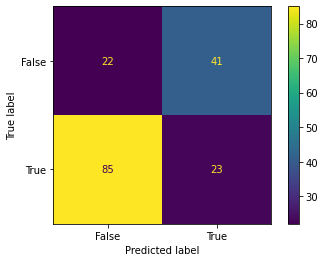

In [48]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [49]:
percentage, class1_ratio, class2_ratio = eval_fidelity(rr_pred, fr_pred)

In [50]:
rr_acc = get_accuracy(y_test, rr_pred)
fr_acc = get_accuracy(y_test, fr_pred)
print("Accuracy of real data: ", rr_acc)
print("Accuracy of synthetic data: ", fr_acc)

Accuracy of real data:  0.9766081871345029
Accuracy of synthetic data:  0.2631578947368421


In [51]:
print(class1_ratio, class2_ratio)

0.14864864864864866 0.15436241610738255


## Final plot

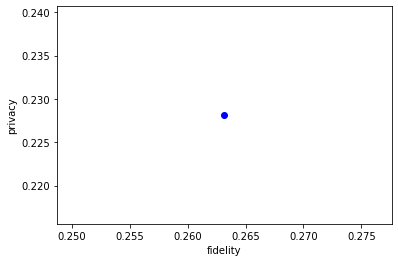

0.2631578947368421 [0.22813601]


In [52]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()
print(percentage, normalized_avg_distance)